In [1]:
%pylab inline
%load_ext line_profiler

from importlib import reload

import scipy
from scipy import interpolate
import skimage

import torch

import model, spline, util
from model import renderer

Populating the interactive namespace from numpy and matplotlib


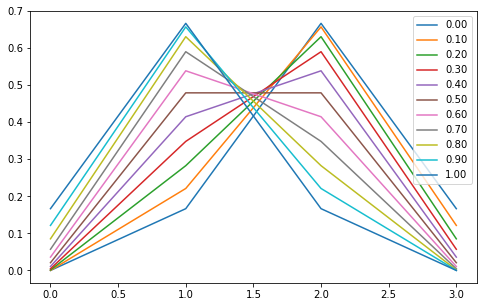

In [2]:
n = 11
fig, axes = subplots(1, 1, figsize=(8,5))
bs = np.linspace(0, 1, n)
for b in bs:
    # print(b)
    # print()
    axes.plot(spline.calculate_bspline_basis(b, k=3), label="{:.2f}".format(b))
    
legend()

In [3]:
reload(spline)
spline.test_calculate_bspline_basis_fast_mode()

%lprun -f spline.test_calculate_bspline_basis_fast_mode spline.test_calculate_bspline_basis_fast_mode()

PASSED all 1000 runs.
PASSED all 1000 runs.


Timer unit: 1e-07 s

Total time: 1.09852 s
File: D:\Github\smlm-dl\smlm_dl\spline.py
Function: test_calculate_bspline_basis_fast_mode at line 152

Line #      Hits         Time  Per Hit   % Time  Line Contents
   152                                           def test_calculate_bspline_basis_fast_mode(iter=1000):
   153         1       2380.0   2380.0      0.0      ks = np.random.randint(1, 4, size=iter)
   154         1         34.0     34.0      0.0      allclose = True
   155      1001      13154.0     13.1      0.1      for i in range(iter):
   156      1000     159055.0    159.1      1.4          p = np.random.rand(9)
   157      1000     674271.0    674.3      6.1          res_fast = calculate_bspline_basis(p, ks[i], True)
   158      1000    4699519.0   4699.5     42.8          res_slow = calculate_bspline_basis(p, ks[i], False)
   159      1000    5413109.0   5413.1     49.3          same = all([np.allclose(a, b) for a, b in zip(res_fast, res_slow)])
   160      1000      20915.

C:\Users\Kenny\AppData\Local\Temp/ipykernel_17420/1027288082.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = skimage.data.human_mitosis()[112:160, 96:128].astype(np.float)


(48, 32)


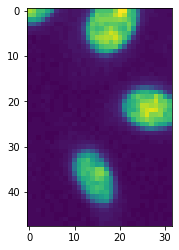

In [4]:
image = skimage.data.human_mitosis()[112:160, 96:128].astype(np.float)
imshow(image)
print(image.shape)

Fitting...


C:\Users\Kenny\anaconda3\envs\smlm-dl\lib\site-packages\torch\autograd\__init__.py:154: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(


Final loss: 0.855	R2: 0.998


C:\Users\Kenny\AppData\Local\Temp/ipykernel_17420/295166216.py:12: RuntimeWarning: divide by zero encountered in log10
  im = axes[2].imshow(np.log10(image_interpolated-image))
C:\Users\Kenny\AppData\Local\Temp/ipykernel_17420/295166216.py:12: RuntimeWarning: invalid value encountered in log10
  im = axes[2].imshow(np.log10(image_interpolated-image))


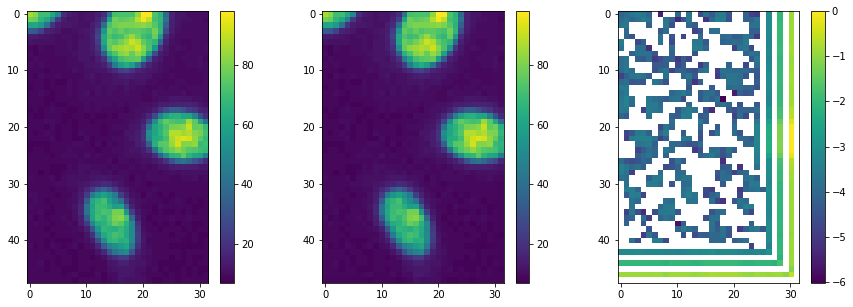

In [5]:
reload(renderer)
# spline_model = spline.Spline2D(image, k=3, fit_image=False)
spline_model = renderer.Spline2DRenderer(image.shape, [], k=3, template_init=image)

image_interpolated = spline_model.render(1).detach().numpy()

fig, axes = subplots(1, 3, figsize=(15, 5))
im = axes[0].imshow(image)
colorbar(im, ax=axes[0])
im = axes[1].imshow(image_interpolated)
colorbar(im, ax=axes[1])
im = axes[2].imshow(np.log10(image_interpolated-image))
colorbar(im, ax=axes[2])

Fitting...
Final loss: 0.855	R2: 0.998


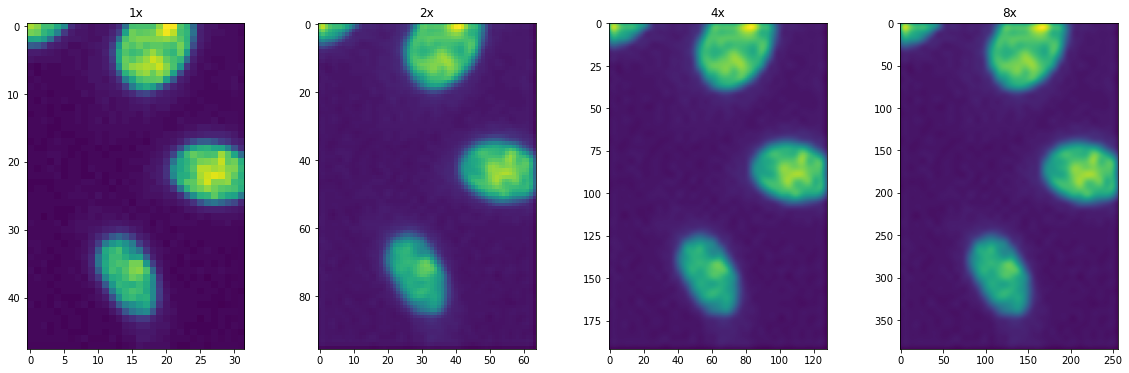

In [6]:
reload(renderer)
# spline_model = spline.Spline2D(image, k=3, fit_image=True)
spline_model = renderer.Spline2DRenderer(image.shape, [], k=3, template_init=image)

# image_interpolated = spline_model.render(1)

fig, axes = subplots(1, 4, figsize=(20, 6))
for i in range(4):
    axes[i].imshow(spline_model.render(2**i).detach().numpy())
    axes[i].set_title("{}x".format(2**i))

(48, 32)
Fitting...
Final loss: 0.855	R2: 0.998


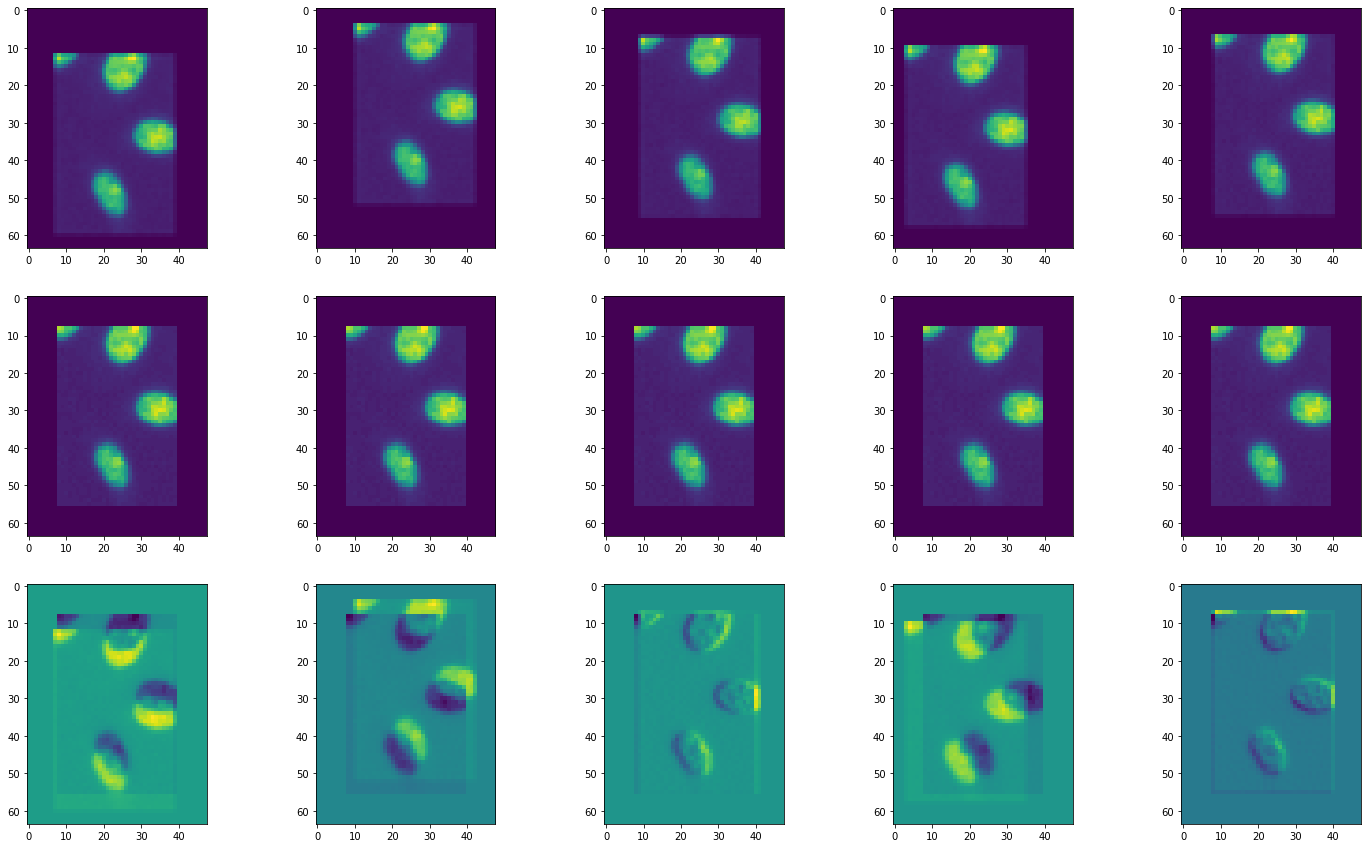

Timer unit: 1e-07 s

Total time: 0.0190668 s
File: D:\Github\smlm-dl\smlm_dl\model\renderer.py
Function: _render_images at line 343

Line #      Hits         Time  Per Hit   % Time  Line Contents
   343                                               def _render_images(self, mapped_params, batch_size=None, raw=False):
   344         1       1737.0   1737.0      0.9          shift_pixel = {key: torch.floor(mapped_params[key]/1).type(torch.int) for key in ['x', 'y']}
   345         1        813.0    813.0      0.4          shifts_subpixel = {key: torch.remainder(mapped_params[key], 1) for key in ['x', 'y']}
   346                                                   
   347         1      73103.0  73103.0     38.3          template = self._calculate_template(shifts_subpixel)
   348         1         17.0     17.0      0.0          if raw:
   349                                                       return template
   350                                                   
   351         1     

In [7]:
reload(renderer)
print(image.shape)
# spline_model = spline.Spline2D(image, k=3, out_size=(64,64), fit_image=True)
padding=8
spline_model = renderer.Spline2DRenderer([dim+2*padding for dim in image.shape], [], k=3, template_init=image)

x = dict()
x['x'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 10
x['y'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 10
x['A'] = 1
x['bg'] = 0
image_interpolated = spline_model(x).detach().numpy()

n = 5
fig, axes = subplots(3, n, figsize=(5*n, 5*3))
for i, j in enumerate(np.linspace(0, image_interpolated.shape[2]-1, n)):    
    j = int(floor(j))
    
    axes[0,i].imshow(image_interpolated[j,0,:,:])
    # z_index = min(int(floor(x['z'][j])), volume.shape[2]-1)
    groundtruth = np.pad(image, ((padding,)*2, (padding,)*2))
    axes[1,i].imshow(groundtruth)
    axes[2,i].imshow(image_interpolated[j,0,:,:]-groundtruth)
    
%lprun -f spline_model._render_images -f spline_model._calculate_template spline_model(x)

(128, 128, 30)


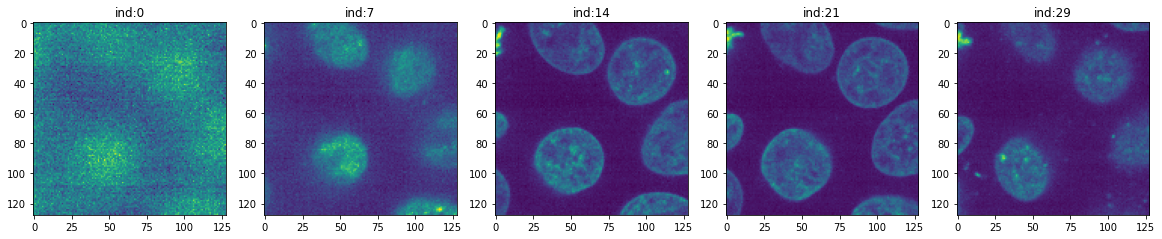

In [8]:
volume = skimage.data.cells3d()[15:-15,1,64:-64,64:-64].astype(np.float32)
volume = np.moveaxis(volume, 0, -1)
print(volume.shape)

n=5
fig, axes = subplots(1, n, figsize=(4*n, 4))
for i, j in enumerate(np.linspace(0, volume.shape[2]-1, n)):
    j = np.floor(j).astype(int)
    axes[i].imshow(volume[:,:,j])
    axes[i].set_title("ind:{}".format(j))

  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 2965889.000	R2: 0.891
Not well fitted.


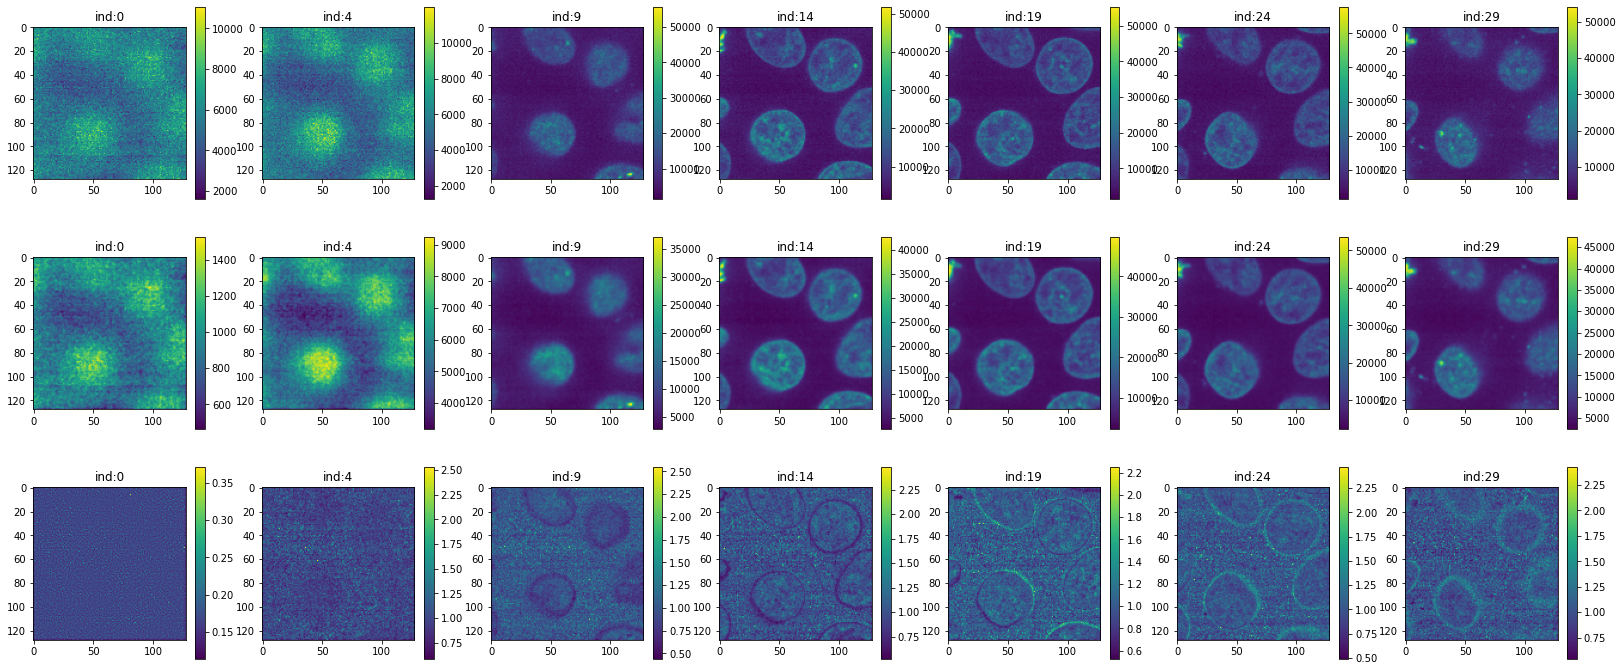

In [9]:
reload(renderer)
spline_model = renderer.Spline3DRenderer(volume.shape[:2], [], k=3, template_init=volume)

volume_interpolated = spline_model.render(1).detach().numpy()

n = 7
fig, axes = subplots(3, n, figsize=(n*4, 3*4))
for i, j in enumerate(np.linspace(0, volume.shape[2]-1, n)):
    j = int(floor(j))
    
    im=axes[0,i].imshow(volume[:,:,j])
    colorbar(im, ax=axes[0,i])
    axes[0,i].set_title("ind:{}".format(j))
    
    im=axes[1,i].imshow(volume_interpolated[:,:,j])
    colorbar(im, ax=axes[1,i])
    axes[1,i].set_title("ind:{}".format(j))
    
    im=axes[2,i].imshow(volume_interpolated[:,:,j] / volume[:,:,j])
    colorbar(im, ax=axes[2,i])
    axes[2,i].set_title("ind:{}".format(j))    

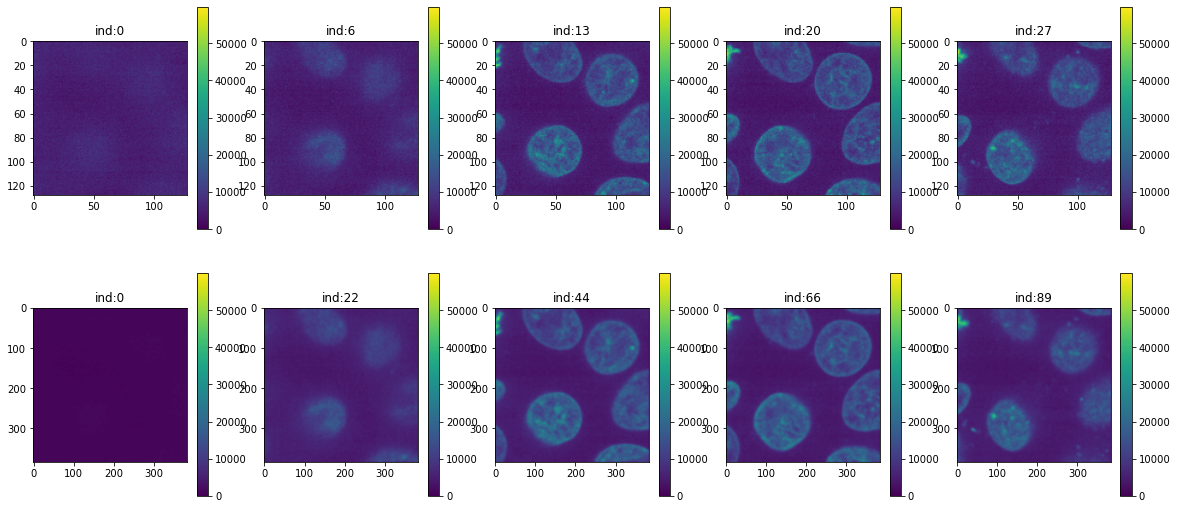

In [10]:
scale = 3
volume_interpolated = spline_model.render(scale).detach().numpy()

vmin = min(volume.min(), volume_interpolated.min())
vmax = max(volume.max(), volume_interpolated.max())

n = 5
fig, axes = subplots(2, n, figsize=(n*4, 3*3))
for i, j in enumerate(np.linspace(0, volume.shape[2]-scale, n)):
    j = int(floor(j))
    im=axes[0,i].imshow(volume[:,:,j], vmin=vmin, vmax=vmax)
    colorbar(im, ax=axes[0,i])
    axes[0,i].set_title("ind:{}".format(j))
    
for i, j in enumerate(np.linspace(0, volume_interpolated.shape[2]-1, n)):
    j = int(floor(j))
    im=axes[1,i].imshow(volume_interpolated[:,:,j], vmin=vmin, vmax=vmax)
    colorbar(im, ax=axes[1,i])
    axes[1,i].set_title("ind:{}".format(j))

(128, 128, 30)


  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 2965889.000	R2: 0.891
Not well fitted.
(128, 128, 30)


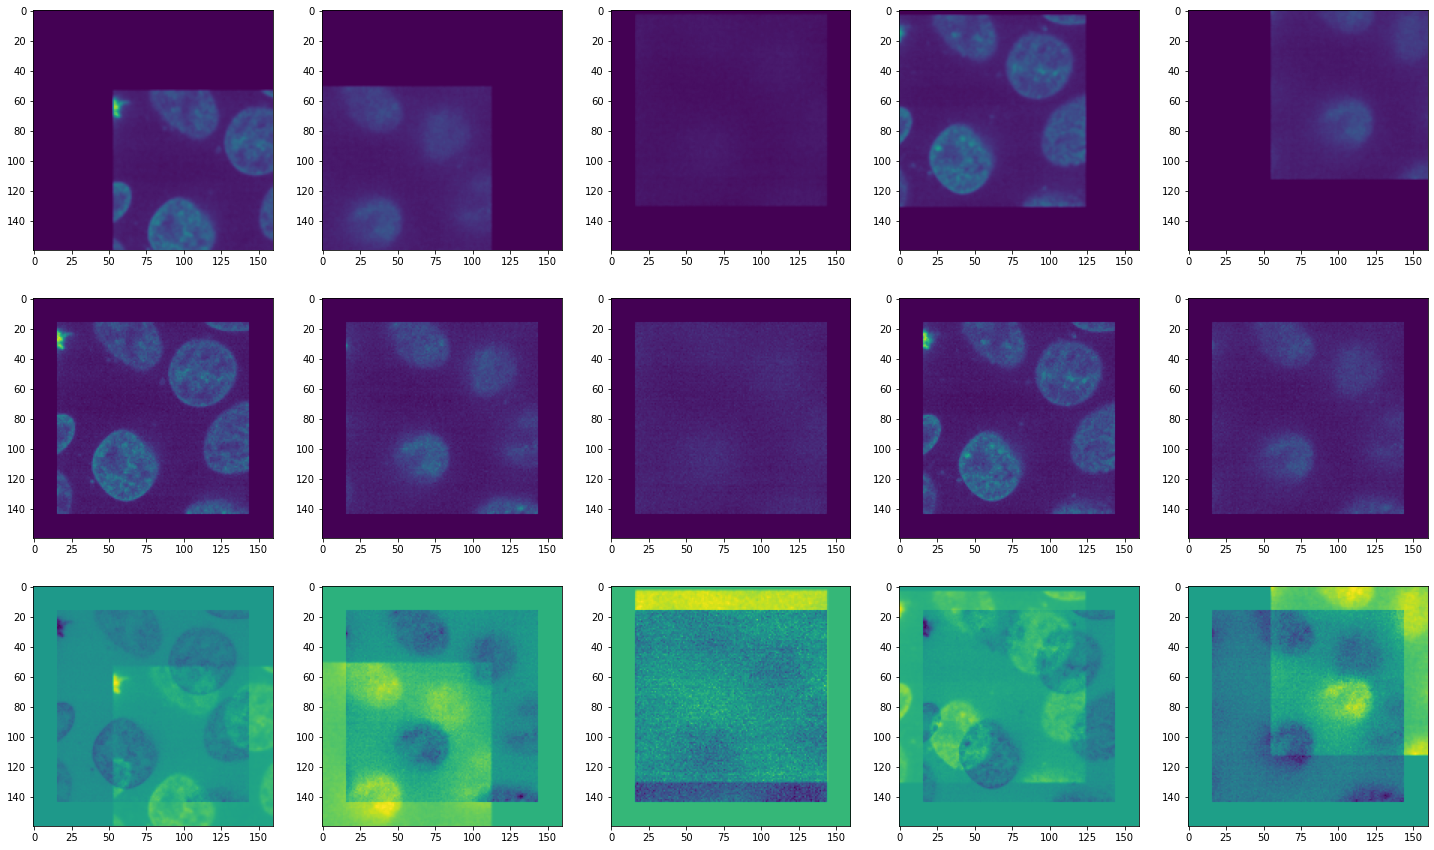

In [11]:
reload(renderer)
print(volume.shape)
padding = 16
spline_model = renderer.Spline3DRenderer([dim+2*padding for dim in volume.shape[:2]], [], k=3, template_init=volume)

print(volume.shape)

x = dict()
x['x'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 2 * 50
x['y'] = (torch.rand((128, 1, 1, 1)) - 0.5) * 2 * 50
x['z'] = torch.rand((128, 1, 1, 1)) * volume.shape[2] - volume.shape[2]//2
x['A'] = 1
x['bg'] = 0
volume_interpolated = spline_model(x).detach().numpy()

vmin = min(volume.min(), volume_interpolated.min())
vmax = max(volume.max(), volume_interpolated.max())

n = 5
fig, axes = subplots(3, n, figsize=(5*n, 5*3))
for i, j in enumerate(np.linspace(0, volume_interpolated.shape[0]-1, n)):
    j = int(floor(j))
    
    axes[0,i].imshow(volume_interpolated[j,0,:,:], vmin=vmin, vmax=vmax)
    z_index = min(int(floor(x['z'][j] + volume.shape[2]//2)), volume.shape[2]-1)
    groundtruth = np.pad(volume[:,:,z_index], ((padding,)*2, (padding,)*2))
    axes[1,i].imshow(groundtruth, vmin=vmin, vmax=vmax)
    axes[2,i].imshow(volume_interpolated[j,0,:,:]-groundtruth)

In [12]:
reload(renderer)
print(volume.shape)
padding = 16
spline_model = renderer.Spline3DRenderer(volume.shape[:2], [], k=3, template_init=volume[:32,:32])

x = dict()
x['x'] = (torch.rand((1024, 1, 1, 1)) - 0.5) * 2 * 50
x['y'] = (torch.rand((1024, 1, 1, 1)) - 0.5) * 2 * 50
x['z'] = torch.rand((1024, 1, 1, 1)) * volume.shape[2]
x['A'] = 1
x['bg'] = 0

# %prun volume_interpolated = spline_model(x)
%lprun -f spline_model.render_images -f spline_model._render_images -f spline_model._calculate_template spline_model(x)

(128, 128, 30)


  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 4028515.250	R2: 0.915


Timer unit: 1e-07 s

Total time: 1.01734 s
File: D:\Github\smlm-dl\smlm_dl\model\renderer.py
Function: render_images at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                               def render_images(self, params, batch_size, as_numpy_array=False):
    29         1    9568304.0 9568304.0     94.1          images = self._render_images(params, batch_size)
    30         1     605043.0 605043.0      5.9          images = images.sum(dim=1, keepdim=True)
    31         1         39.0     39.0      0.0          if as_numpy_array:
    32                                                       images = images.detach().numpy()
    33         1         10.0     10.0      0.0          return images

Total time: 0.93902 s
File: D:\Github\smlm-dl\smlm_dl\model\renderer.py
Function: _render_images at line 485

Line #      Hits         Time  Per Hit   % Time  Line Contents
   485                                               def _render_ima

tensor([-0.5000, -0.2500,  0.0000,  0.2500,  0.5000])
(32, 32, 64)
Fitting...
Final loss: 0.000	R2: 1.000
torch.Size([5, 1, 32, 32])
-0.09334467 1.2008919


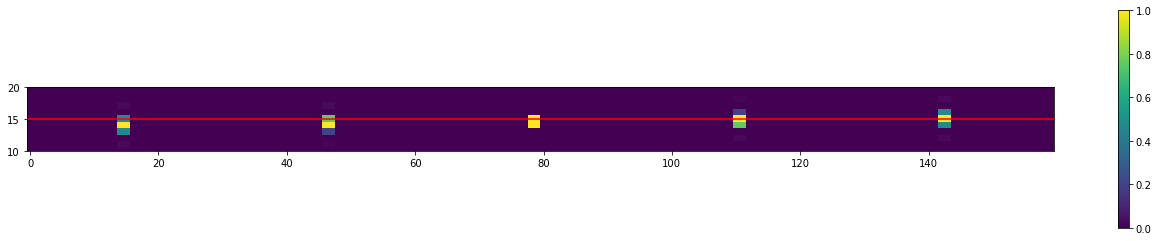

In [13]:
ref_psf = np.zeros((32,32,64))
ref_psf[14:16,14:16,31:33] = 1
n = 5
mapped_params = {'x': torch.linspace(-1, 1, n).reshape(-1, 1, 1, 1)*0.5,
                 # 'x': torch.zeros((n, 1, 1, 1)),
                 'y': torch.linspace(-16, 16, n).reshape(-1, 1, 1, 1)*0,
                 # 'z': torch.zeros((n, 1, 1, 1)),
                 'A': torch.ones((n, 1, 1, 1)),
                 'bg': torch.zeros((n, 1, 1, 1)),
                }
print(mapped_params['x'].squeeze())

print(ref_psf.shape)
spline_renderer = model.Spline2DRenderer(ref_psf.shape[:2], [], k=3, template_init=ref_psf[:,:,ref_psf.shape[2]//2])


pred = spline_renderer(mapped_params)
print(pred.shape)

tiled_images = util.tile_images(pred.detach().numpy(), n)[0,0]
print(tiled_images.min(), tiled_images.max())

fig, ax = subplots(1, 1, figsize=(n*4+3, 4))
im = ax.imshow(tiled_images, vmin=0, vmax=1)
colorbar(im, ax=ax)
ax.set_ylim(10, 20)
ax.axhline(15, c='red')

{3: -0.1369795996982004, 4: 0.0767269400559496, 5: 2, 6: -0.3260092012809702, 7: -0.26280622708728885, 8: -0.44471922841072364, 9: 0.14088863410679398, 10: -0.08778124331377868, 11: 0.15936454870920513, 12: 0.38225423104460077, 13: -0.02787758782664551, 14: -0.4748994365546736, 15: 0.13465043825731626, 16: -0.09453500479565036, 17: -0.15461473214854493, 18: 0.47574449880029657, 19: 0.2894686410352192, 20: 0.25454679419156834}
[-31.5 -30.5 -29.5 -28.5 -27.5 -26.5 -25.5 -24.5 -23.5 -22.5 -21.5 -20.5
 -19.5 -18.5 -17.5 -16.5 -15.5 -14.5 -13.5 -12.5 -11.5 -10.5  -9.5  -8.5
  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.5  -0.5   0.5   1.5   2.5   3.5
   4.5   5.5   6.5   7.5   8.5   9.5  10.5  11.5  12.5  13.5  14.5  15.5
  16.5  17.5  18.5  19.5  20.5  21.5  22.5  23.5  24.5  25.5  26.5  27.5
  28.5  29.5  30.5  31.5]
29:	 [id = 29.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = -2.500,],
21:	 [id = 21.000,], [A = 1.000,], [bg = 0.000,], [x = 0.000,], [y = 0.000,], [z = -10

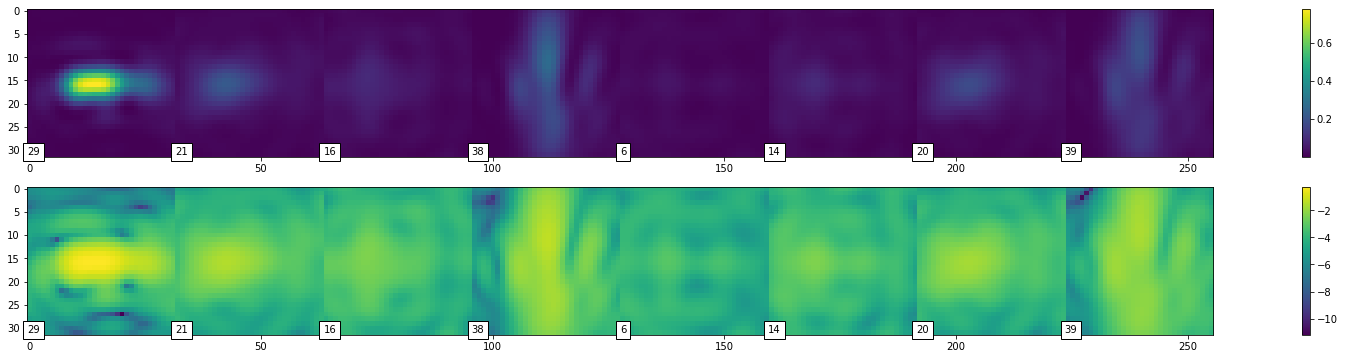

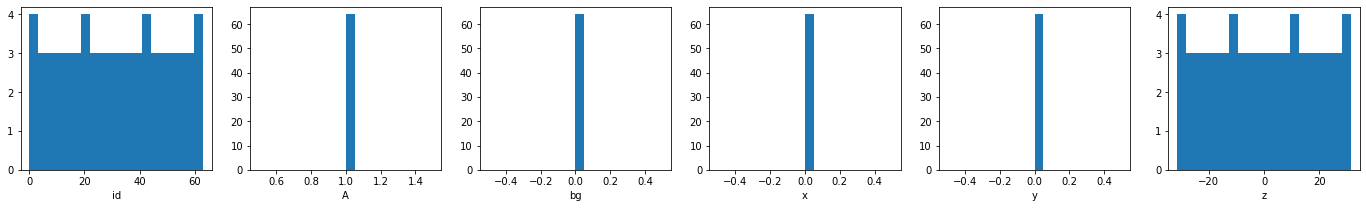

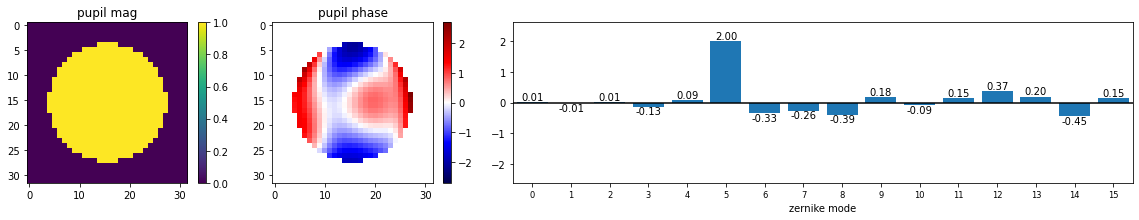

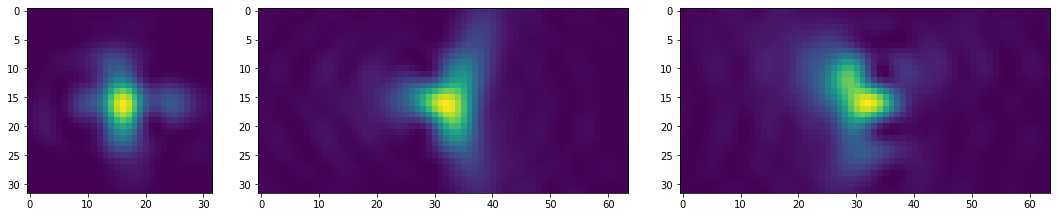

In [14]:
import dataset
reload(dataset)

psf_zerns = dict()
for z in range(3, 21):
    psf_zerns[z] = np.random.uniform(-0.5, 0.5)
psf_zerns.update({5:2 })

print(psf_zerns)

length = 64
image_params_preset = {'A': np.ones(length),
                       'x': np.zeros(length),
                       'y': np.zeros(length),
                       'bg': np.zeros(length),
                       'z': np.linspace(-31.5, 31.5, length)}
print(image_params_preset['z'])

settings = {
    # 'out_size': (64,64),
    # 'length': (length, 1),
    'dropout_p': 0,
    # 'psf_params': {'z':[-10,10]},
    'psf_zerns': psf_zerns,
    # 'noise_params': {},
    'normalize': False,
    # 'padding': (4,4),
    # 'random_z': True,
    "augmentations":{},
    # "augmentations":{"pixel shift":(4,4), }#"add noise":0.1},
}

reference_psf_data = dataset.FourierOpticsPSFDataset(length=64,
                                                     noise_params={},
                                                     image_params_preset=image_params_preset,
                                                    **settings)
dataset.inspect_images(reference_psf_data)
volume = np.asarray([image for (image, label) in reference_psf_data])
volume = volume[:,0,...]
volume = np.moveaxis(volume, 0, -1)
print(volume.shape)

ref_psf = volume[:,:,:]

fig, axes = subplots(1, 3, gridspec_kw={'width_ratios':[1, 2, 2]}, figsize=(15,3))
axes[0].imshow(volume[:,:,volume.shape[2]//2])
axes[1].imshow(volume[:,volume.shape[1]//2,:])
axes[2].imshow(volume[volume.shape[0]//2,:,:])
fig.tight_layout()

training_data = dataset.FourierOpticsPSFDataset(length = 128,
                                                psf_params={'z':[-10,10]},
                                                **settings)



  0%|          | 0/10 [00:00<?, ?it/s]

Final loss: 0.000	R2: 0.989


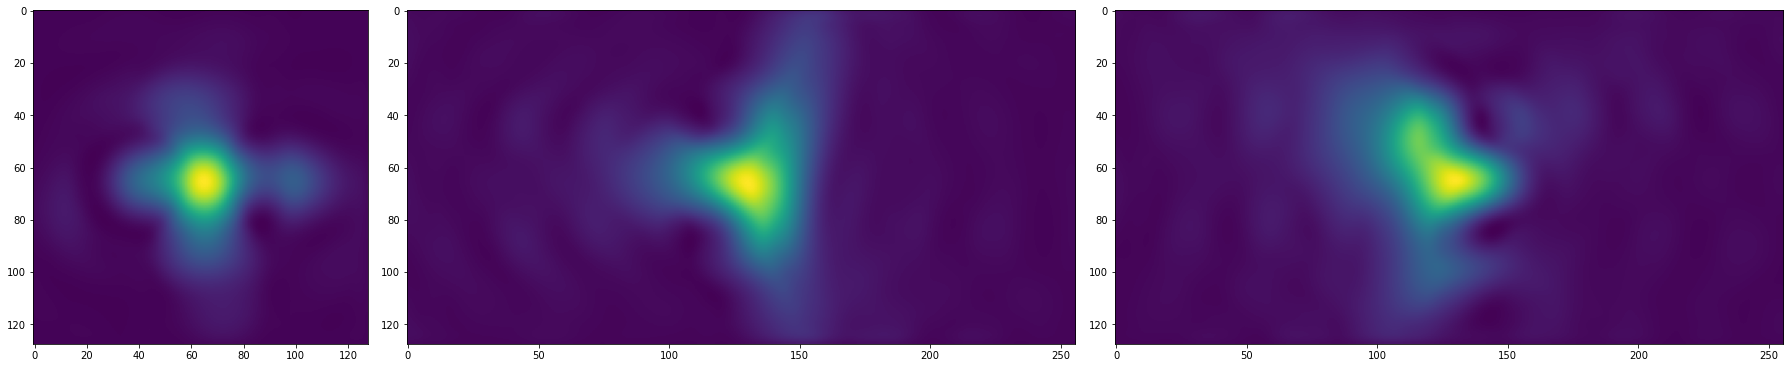

In [15]:
reload(model.renderer)
reload(model)
# reload(trainer)
# ref_psf = np.zeros((32,32,64))
# ref_psf[14:16,14:16,31:33] = 1
fitting_model = model.BaseFitModel(renderer_class=model.Spline3DRenderer,
                                   encoder_class=model.ConvImageEncoderModel,
                                   fit_params=['x','y','A','bg','z'],
                                   renderer_params={'k':3,
                                                    'template_init':ref_psf,
                                                   }
                                     )

volume = fitting_model.renderer.render(4).detach().numpy()

fig, axes = subplots(1, 3, gridspec_kw={'width_ratios':[1, 2, 2]}, figsize=(25,5))
axes[0].imshow(volume[:,:,volume.shape[2]//2])
axes[1].imshow(volume[:,volume.shape[1]//2,:])
axes[2].imshow(volume[volume.shape[0]//2,:,:])
fig.tight_layout()

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])
torch.Size([5, 1, 32, 32])
-0.0048540058 0.97238225


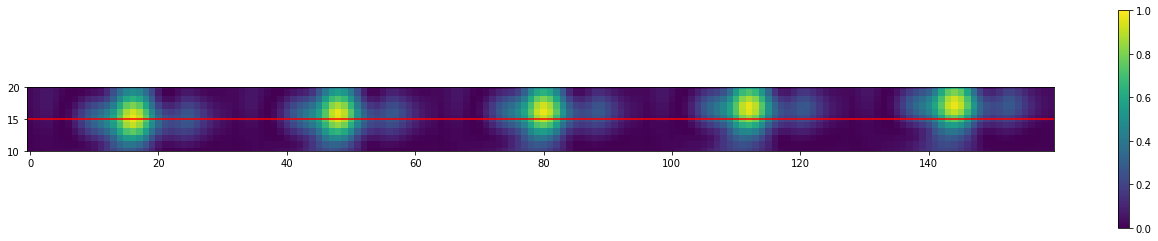

In [16]:
n = 5
mapped_params = {'x': torch.linspace(-1, 1, n).reshape(-1, 1, 1, 1)*1,
                 # 'x': torch.zeros((n, 1, 1, 1)),
                 'y': torch.linspace(-16, 16, n).reshape(-1, 1, 1, 1)*0,
                 'z': torch.zeros((n, 1, 1, 1)),
                 'A': torch.ones((n, 1, 1, 1)),
                 'bg': torch.zeros((n, 1, 1, 1)),
                }
print(mapped_params['x'].squeeze())

pred = fitting_model.renderer(mapped_params)
print(pred.shape)

tiled_images = util.tile_images(pred.detach().numpy(), n)[0,0]
print(tiled_images.min(), tiled_images.max())

fig, ax = subplots(1, 1, figsize=(n*4+3, 4))
im = ax.imshow(tiled_images, vmin=0, vmax=1)
colorbar(im, ax=ax)
ax.set_ylim(10, 20)
ax.axhline(15, c='red')